In [5]:
import numpy as np
import pandas as pd
from skimage.color import rgb2gray
from PIL import Image
from tifffile import imread
import tifffile
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.morphology import disk, binary_dilation
from io import StringIO
import imageio
import os
import rawpy 

In [7]:
!pip install rawpy


In [2]:
image = "wide/drdurr_image.dng"

In [6]:
def dng_to_linear_tiff(src_path, dst_path=None, bake_orientation=True):
    arr = None
    orientation_in = None
    method = None

    # Try direct tifffile first
    try:
        with tifffile.TiffFile(src_path) as tf:
            p0 = tf.pages[0]
            arr = p0.asarray()
            orientation_in = getattr(p0, "orientation", None)
            method = "tifffile"
    except Exception as e:
        print(f"[tifffile] Could not decode ({e}). Trying rawpy…")
        with rawpy.imread(src_path) as raw:
            arr = raw.postprocess(
                gamma=(1, 1),          # keep linear
                no_auto_bright=True,
                output_bps=16,
                user_wb=[1, 1, 1, 1],  # no WB scaling
                use_camera_wb=False
            )
            orientation_in = None  # rawpy already applies orientation
            method = "rawpy"

    if arr.ndim != 3 or arr.shape[2] != 3 or arr.dtype != np.uint16:
        raise ValueError(f"{src_path}: unexpected shape/dtype: {arr.shape}, {arr.dtype}")

    # Bake orientation if needed (rawpy already bakes it in)
    if bake_orientation and method == "tifffile" and orientation_in == 6:
        arr = np.rot90(arr, k=3, axes=(0, 1))  # 90° CW
        orientation_out = 1
    else:
        orientation_out = orientation_in if orientation_in is not None else 1

    if dst_path is None:
        base, _ = os.path.splitext(src_path)
        dst_path = base + "_linear16.tif"

    tifffile.imwrite(
        dst_path,
        arr,
        dtype="uint16",
        photometric="rgb",
        compression=None,
        metadata=None,
        description=None
    )

    return {
        "src": src_path,
        "dst": dst_path,
        "shape": arr.shape,
        "dtype": str(arr.dtype),
        "orientation_in": orientation_in,
        "orientation_out": orientation_out,
        "method": method
    }

In [7]:
src = "/Users/hyunseo.lee/smartphone_capillaroscope/wide/drdurr_image.dng"
info = dng_to_linear_tiff(src, bake_orientation=True)
info

[tifffile] Could not decode (TiffPage 0: 52546 is not a known COMPRESSION). Trying rawpy…


LibRawFileUnsupportedError: b'Unsupported file format or not RAW file'

In [ ]:
# Cell 3: batch convert a set of DNGs

from glob import glob

inputs = glob("/Users/hyunseo.lee/smartphone_capillaroscope/wide/*.dng")
results = []
for src in inputs:
    try:
        results.append(dng_to_linear_tiff(src, bake_orientation=True))
    except Exception as e:
        results.append({"src": src, "error": str(e)})

results  # inspect a quick summary


In [ ]:
# Cell 4: verify one output's shape/range

import tifffile
import numpy as np

out_path = info["dst"]
with tifffile.TiffFile(out_path) as tf:
    arr = tf.pages[0].asarray()

arr.shape, arr.dtype, int(arr.min()), int(arr.max())


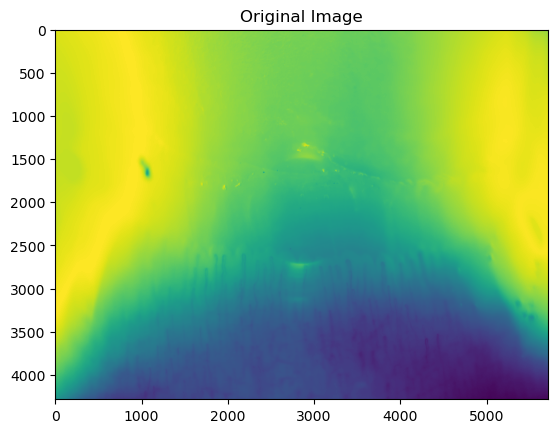

In [11]:
image_green = "wide/C2-capillaries_green.tif"
img = imread(image_green)
plt.imshow(img)
plt.title("Original Image")
plt.show()

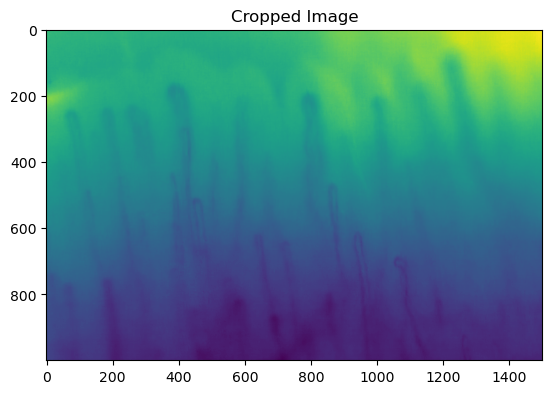

In [12]:
cropped_img = img[2500:3500, 3000:4500] 
plt.imshow(cropped_img)
plt.title("Cropped Image")
plt.show()

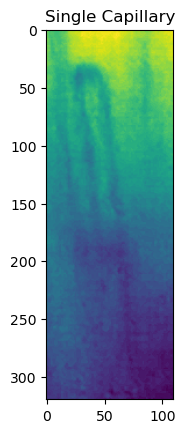

In [16]:
one_capillary = cropped_img[480:800, 420:530]
plt.imshow(one_capillary)
plt.title("Single Capillary")
plt.show()